# AutoETS

AutoETS (Auto Exponential Smoothing) is an automatic forecasting method that applies exponential smoothing to time series data with trend and seasonality.

**Key Ideas**  
- Automatically selects the best exponential smoothing model based on information criteria (AIC, AICC or BIC).
- Provides point, variance, quantile, interval and distribution forecasts.
- Can be used with different types of seasonality or no seasonality at all.
- sktime package: provide multiple probabilistic forecasting methods and possible to implement its own custom probabilistic forecaster.

**Model documentation**: 

- github: https://github.com/sktime/sktime
- AutoETS: https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.ets.AutoETS.html
- sktime notebook proba forecasting: https://github.com/sktime/sktime/blob/main/examples/01b_forecasting_proba.ipynb
- user guide: https://www.sktime.net/en/v0.19.2/examples/01b_forecasting_proba.html
- guide to build your own probabilistic forecaster: https://www.sktime.net/en/stable/developer_guide/add_estimators.html

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            },
                "weight": weight
}
```

A **mixture density**, such as the gaussion mixture $\sum_{i=1}^{K} w_i \mathcal{N}(Y_t | \mu_i, \sigma_i^2)$ allows for capturing multi-modal distributions and approximate more complex distributions.

![proba_forecast_v3](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v3.png?raw=true)


**Probabilistic Forecasting** is particularly valuable in supply chain management. Below are some interesting resources for a deeper understanding:  

- [Probabilistic Forecasting](https://www.lokad.com/probabilistic-forecasting-definition/) – Overview of probabilistic forecasting and its applications.  
- [Quantile Forecasting](https://www.lokad.com/quantile-regression-time-series-definition/) – Explanation of quantile-based forecasting methods.  
- **Evaluation Metrics:**  
  - [Continuous Ranked Probability Score (CRPS)](https://www.lokad.com/continuous-ranked-probability-score/)  
  - [Cross-Entropy](https://www.lokad.com/cross-entropy-definition/)  
  - [Pinball Loss](https://www.lokad.com/pinball-loss-function-definition/)

In [ ]:
# Requirements
!pip install birdgame sktime

In [1]:
# Standard library imports
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

# Birdgame package imports
from birdgame.trackers.trackerbase import TrackerBase
from birdgame.visualization.viz_autoets import visualize_sktime_model

### Warm up example: AutoETS

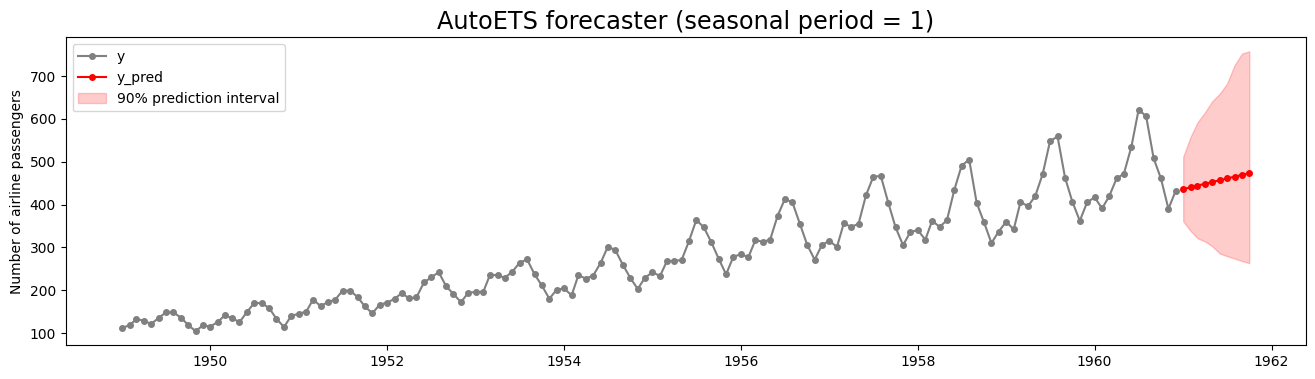

Variance estimation:


,Number of airline passengers
1961-01,2044.811731
1961-02,4353.961414
1961-03,6580.476059
1961-04,7512.550362
1961-05,10192.722469
1961-06,11900.767666
1961-07,14038.977908
1961-08,15260.429307
1961-09,16367.726865
1961-10,19076.431407


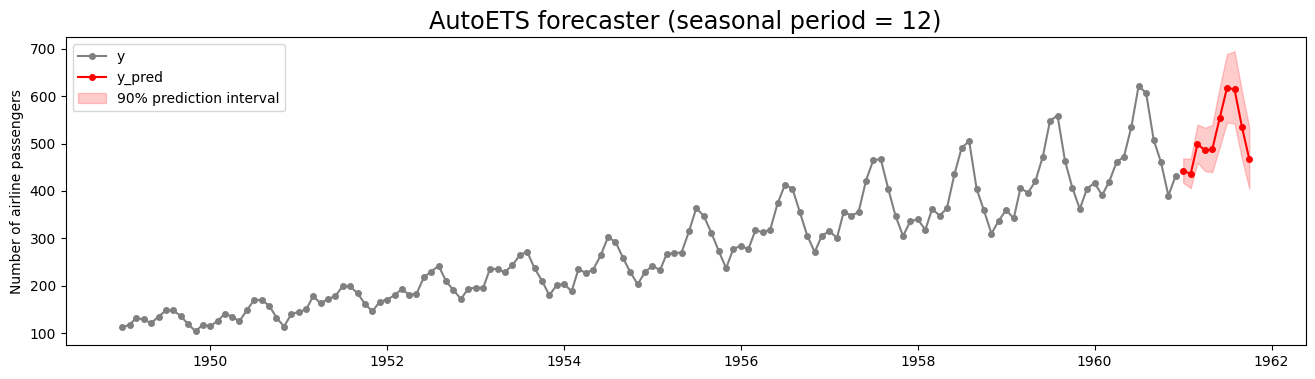

Variance estimation:


,Number of airline passengers
1961-01,225.679051
1961-02,323.026884
1961-03,592.547784
1961-04,738.250695
1961-05,883.186863
1961-06,1533.254296
1961-07,2147.204854
1961-08,2272.448689
1961-09,1896.595658
1961-10,1582.700895


In [2]:
# Run AutoETS sktime model for different seasonal period
for sp in [1, 12]:
    visualize_sktime_model(seasonal_period=sp)

In [4]:
import numpy as np
import threading
import time
import warnings
from sktime.forecasting.ets import AutoETS
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")


class AutoETSsktimeTracker(TrackerBase):
    """
    A model that tracks the dove location using AutoETS.

    Parameters
    ----------
    horizon : int
        The number of time steps into the future that predictions should be made for.
    train_model_frequency : int
        The frequency at which the sktime model will be retrained based on the count of observations 
        ingested. This determines how often the model will be updated with new data.
    num_data_points_max : int
        The maximum number of data points to use for training the sktime model.
    warmup : int
        The number of ticks taken to warm up the model (wealth does not change during this period).
    use_threading : bool
        Whether to retrain the model asynchronously in a background thread.  
        /!/ Set this to True for live data streams where each `tick()`  
        and `predict()` call must complete within ~50 ms.  
        When enabled, retraining happens in parallel without blocking predictions.
    """

    def __init__(self, horizon=3):
        super().__init__(horizon)
        self.current_x = None
        self.last_observed_data = [] # Holds the last few observed data points
        self.prev_t = 0

        self.train_model_frequency = Constants.TRAIN_MODEL_FREQUENCY
        self.num_data_points_max = Constants.NUM_DATA_POINTS_MAX

        # Number of steps to predict
        steps = 1 # only one because the univariate serie will only have values separated of at least HORIZON time
        self.fh = np.arange(1, steps + 1)

        # Fit the AutoETS forecaster (no seasonality)
        self.forecaster = AutoETS(auto=True, sp=1, information_criterion="aic")
        self.scale = 1e-6

        # or Fit the AutoARIMA forecaster
        # self.forecaster = AutoARIMA(max_p=2, max_d=1, max_q=2, maxiter=10)

        self.warmup_cutoff = Constants.WARMUP_CUTOFF
        self.tick_count = 0

        # Threading tools
        self.use_threading = Constants.USE_THREADING
        self._lock = threading.Lock()
        if self.use_threading:
            self._cond = threading.Condition(self._lock)
            self._new_data = None
            self._stop_worker = False
            self._worker_thread = threading.Thread(target=self._worker_retrain_model_async, daemon=True)
            self._worker_thread.start()

    # ------------------- Tick -------------------
    def tick(self, payload, performance_metrics=None):
        """
        Ingest a new record (payload), store it internally and update the model.

        Function signature can also look like tick(self, payload) since performance_metrics 
        is an optional parameter.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        performance_metrics : dict (is optional)
            Dict containing 'wealth', 'likelihood_ewa', 'recent_likelihood_ewa'.
        """
        # # To see the performance metrics on each tick
        # print(f"performance_metrics: {performance_metrics}")

        # # Can also trigger a warmup by checking if a performance metric drops below a threshold
        # if performance_metrics['recent_likelihood_ewa'] < 1.1:
        #     self.tick_count = 0
        
        x = payload["dove_location"]
        t = payload["time"]
        self.add_to_quarantine(t, x)
        self.current_x = x

        if t > self.prev_t + self.horizon:
            self.last_observed_data.append(x)
            self.prev_t = t

        prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:
            if self.count > 10 and self.count % self.train_model_frequency == 0:
                # Construct 'y' as an univariate serie
                y = np.array(self.last_observed_data)[-self.num_data_points_max:]

                # Fit sktime model and variance prediction
                if self.use_threading:
                    # Signal background thread
                    with self._cond:
                        self._new_data = y
                        self._cond.notify()
                else:
                    self._retrain_model_sync(y)

                # Update last observed data (to limit memory usage as it will be run on continuous live data)
                self.last_observed_data = self.last_observed_data[-(self.num_data_points_max + 2):]

            self.count += 1

        self.tick_count += 1

    # ------------------- Prediction -------------------
    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution,
        modeled as a Gaussian distribution.

        If the model is in the warmup period, return None.
        """
        with self._lock:
            # Check if the model is warming up
            if self.tick_count < self.warmup_cutoff or self.forecaster is None:
                return None

            # the central value (mean) of the gaussian distribution will be represented by the current value
            # but you can get point forecast from 'self.forecaster.predict(fh=self.fh[-1])[0][0]'
            loc = self.current_x
            # we predicted scale during tick training
            scale = max(getattr(self, "scale", 1e-6), 1e-6)

            # If you want to predict variance for each prediction
            # scale = self.forecaster.predict_var(fh=self.fh)
            # scale = np.sqrt(scale.values.flatten()[-1])

        # time.sleep(0.01)  # mimic short inference delay

        # Return the prediction density
        components = {
            "density": {
                "type": "builtin",
                "name": "norm",
                "params": {"loc": loc, "scale": scale},
            },
            "weight": 1,
        }

        return {"type": "mixture", "components": [components]}

    # ------------------- Model training -------------------
    def _fit(self, y):
        # Fit a clone sktime model (at least a cloned model is required in case of asynchronous training)
        new_forecaster = self.forecaster.clone()
        new_forecaster.fit(y, fh=self.fh)
        # Variance prediction
        var = new_forecaster.predict_var(fh=self.fh)
        scale = np.sqrt(var.values.flatten()[-1])

        return new_forecaster, scale

    def _retrain_model_sync(self, y):
        """Synchronous retraining"""
        start_time = time.perf_counter()
        self.forecaster, self.scale = self._fit(y)
        # print(f"Sync retrain time: {(time.perf_counter()- start_time)*1000:.2f} ms") # check training time

    def _worker_retrain_model_async(self):
        """Asynchronous retraining in a background worker"""
        while True:
            with self._cond:
                # Wait until new data is available
                while self._new_data is None:
                    self._cond.wait()
                y = self._new_data  # get the data to train on
                self._new_data = None  # clear it (so next signal is new data)

            # Train the model outside the lock (so predict() can still run)
            new_forecaster, scale = self._fit(y)

            # Swap the trained model safely
            with self._lock:
                self.forecaster = new_forecaster
                self.scale = scale
            # print("Async retraining done")


### Tracker experimentation

The model is experimented on a data generator using the [density_pdf](https://github.com/microprediction/densitypdf/blob/main/densitypdf/__init__.py) scoring. For a gaussian distribution, it is:

$$\text{pdf\_score}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

This metric measures how well the predicted distribution aligns with the observed data. **A higher pdf_score indicates a more accurate prediction.**

In [5]:
# Parameters
class Constants:
    TRAIN_MODEL_FREQUENCY=50
    NUM_DATA_POINTS_MAX=20
    WARMUP_CUTOFF=0
    USE_THREADING=True # Set this to True for live data streams where each `tick()` and `predict()` call must complete within ~50 ms

### Run on a remote static data file

In [6]:
run_on_live_data = False
Constants.USE_THREADING = run_on_live_data
# do not use threading for static data, the stream advances much faster
# than the training process, so asynchronous retraining would lag behind (or use time.sleep())

# Initialize Tracker
tracker = AutoETSsktimeTracker()

# Run on remote data
tracker.test_run(live=run_on_live_data)

0it [00:00, ?it/s]

My likelihood score: 2.1607 VS Benchmark likelihood score: 3.5232
     .... and mine is worse. Ratio is 0.61327
My likelihood score: 2.5571 VS Benchmark likelihood score: 3.6554
     .... and mine is worse. Ratio is 0.69953
My likelihood score: 2.7347 VS Benchmark likelihood score: 3.6559
     .... and mine is worse. Ratio is 0.74804
My likelihood score: 2.6441 VS Benchmark likelihood score: 3.6221
     .... and mine is worse. Ratio is 0.73000
My likelihood score: 2.7649 VS Benchmark likelihood score: 3.6524
     .... and mine is worse. Ratio is 0.75700
My likelihood score: 2.8293 VS Benchmark likelihood score: 3.6755
     .... and mine is worse. Ratio is 0.76979
My likelihood score: 2.8350 VS Benchmark likelihood score: 3.6987
     .... and mine is worse. Ratio is 0.76648
My likelihood score: 2.8741 VS Benchmark likelihood score: 3.6998
     .... and mine is worse. Ratio is 0.77682
My likelihood score: 2.8657 VS Benchmark likelihood score: 3.6989
     .... and mine is worse. Ratio is 

### Run on live data

In [ ]:
run_on_live_data = True
Constants.USE_THREADING = run_on_live_data

# Initialize Tracker
tracker = AutoETSsktimeTracker()

# Run on live data
tracker.test_run(live=run_on_live_data)

0it [00:00, ?it/s]

My likelihood score: 2.6910 VS Benchmark likelihood score: 4.3065
     .... and mine is worse. Ratio is 0.62487
My likelihood score: 3.1591 VS Benchmark likelihood score: 4.2371
     .... and mine is worse. Ratio is 0.74558
My likelihood score: 3.2428 VS Benchmark likelihood score: 4.1633
     .... and mine is worse. Ratio is 0.77890
My likelihood score: 3.2342 VS Benchmark likelihood score: 4.1413
     .... and mine is worse. Ratio is 0.78097
My likelihood score: 3.3423 VS Benchmark likelihood score: 4.1643
     .... and mine is worse. Ratio is 0.80263
My likelihood score: 3.3970 VS Benchmark likelihood score: 4.1149
     .... and mine is worse. Ratio is 0.82552
My likelihood score: 3.4636 VS Benchmark likelihood score: 4.1245
     .... and mine is worse. Ratio is 0.83976
My likelihood score: 3.4788 VS Benchmark likelihood score: 4.1089
     .... and mine is worse. Ratio is 0.84664
My likelihood score: 3.4365 VS Benchmark likelihood score: 3.9871
     .... and mine is worse. Ratio is 

### An animated run

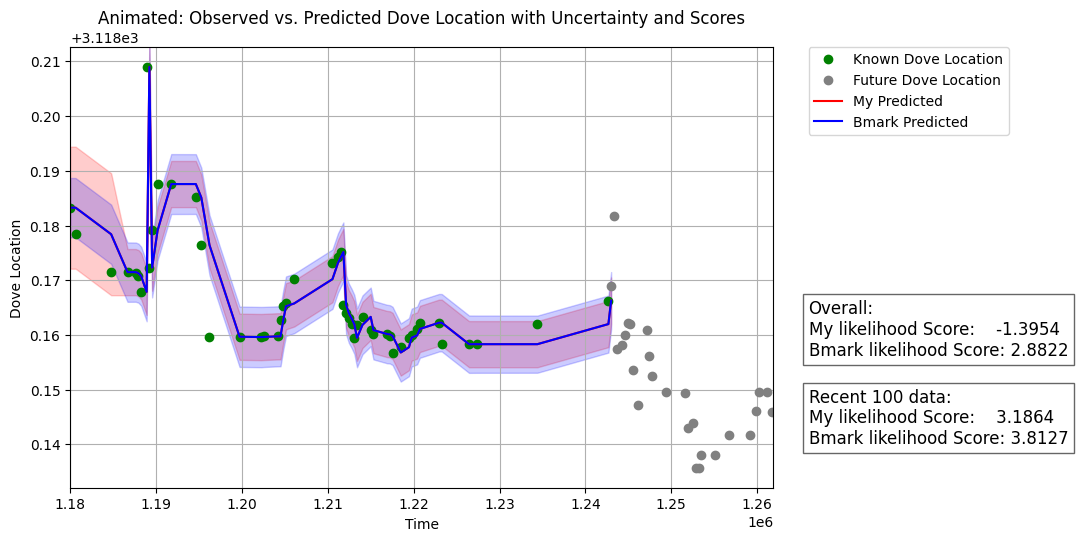


 Run stopped by user.


In [32]:
%matplotlib inline
from IPython.display import HTML

run_on_live_data = False
Constants.USE_THREADING = run_on_live_data

tracker = AutoETSsktimeTracker()

try:
    animated = tracker.test_run_animated(live=run_on_live_data, from_notebook=True)

    # Display animation in notebook
    HTML(animated.to_jshtml())

except KeyboardInterrupt:
    print("\n Run stopped by user.")
# Interrupt cell to stop run

### Design your own testing process and statistical analysis

In [24]:
from birdgame.model_benchmark.emwavartracker import EMWAVarTracker
from birdgame.trackers.tracker_evaluator import TrackerEvaluator
from birdgame.datasources.livedata import live_data_generator
from birdgame.datasources.remotetestdata import remote_test_data_generator
from birdgame.visualization.utils import get_loc_and_scale


live = False
Constants.USE_THREADING = live
step_print = 1000
warmup_iterations = 300
max_iterations = 10000

tracker = AutoETSsktimeTracker()

benchmark_tracker = EMWAVarTracker(horizon=tracker.horizon)
my_run, bmark_run = TrackerEvaluator(tracker), TrackerEvaluator(benchmark_tracker)

gen = live_data_generator() if live else remote_test_data_generator()

store_pred = []
try:
    for i, payload in enumerate(tqdm(gen)):

        my_run.tick_and_predict(payload)
        bmark_run.tick_and_predict(payload)

        if i > warmup_iterations:
            score = my_run.scores[-1]
            
            loc, scale = get_loc_and_scale(my_run.latest_valid_prediction)
            store_pred.append({
                "time": my_run.time,
                "prediction": my_run.latest_valid_prediction,
                "loc": loc,
                "scale": scale,
                "dove_location": my_run.dove_location,
                "score": score,
                "log_score": np.log(1e-10 + score)
            })

        if (i + 1) % step_print == 0:
            print(f"My likelihood score: {my_run.overall_likelihood_score():.4f} VS Benchmark likelihood score: {bmark_run.overall_likelihood_score():.4f}")

        if i > max_iterations:
            break

    print(f"My likelihood score: {my_run.overall_likelihood_score():.4f} VS Benchmark likelihood score: {bmark_run.overall_likelihood_score():.4f}")
except KeyboardInterrupt:
    print("Interrupted")

0it [00:00, ?it/s]

My likelihood score: 2.1611 VS Benchmark likelihood score: 3.5232
My likelihood score: 2.5613 VS Benchmark likelihood score: 3.6554
My likelihood score: 2.7402 VS Benchmark likelihood score: 3.6559
My likelihood score: 2.6379 VS Benchmark likelihood score: 3.6221
My likelihood score: 2.7594 VS Benchmark likelihood score: 3.6524
My likelihood score: 2.8234 VS Benchmark likelihood score: 3.6755
My likelihood score: 2.8300 VS Benchmark likelihood score: 3.6987
My likelihood score: 2.8675 VS Benchmark likelihood score: 3.6998
My likelihood score: 2.8602 VS Benchmark likelihood score: 3.6989
My likelihood score: 2.9348 VS Benchmark likelihood score: 3.7181
My likelihood score: 2.9351 VS Benchmark likelihood score: 3.7182


In [25]:
from birdgame.visualization.utils import summarize_predictions
stats_summary, pred_summary = summarize_predictions(store_pred, skip_length=0)

Mean: {'score': 68.726, 'log_score': 3.043}
Median: {'score': 56.276, 'log_score': 4.03}
Std: {'score': 56.465, 'log_score': 4.288}

Prediction Data:


,time,prediction,loc,scale,dove_location,score,log_score
0,1.341040e+06,"{'type': 'mixture', 'components': [{'density':...",3118.13669,0.00547,3118.13391,64.13316,4.16096
1,1.341358e+06,"{'type': 'mixture', 'components': [{'density':...",3118.13391,0.00541,3118.13986,40.27555,3.69574
2,1.341676e+06,"{'type': 'mixture', 'components': [{'density':...",3118.13986,0.00541,3118.13945,73.54127,4.29785
3,1.341994e+06,"{'type': 'mixture', 'components': [{'density':...",3118.13945,0.00541,3118.13908,73.57059,4.29825
4,1.342313e+06,"{'type': 'mixture', 'components': [{'density':...",3118.13908,0.00541,3118.14338,53.71932,3.98377
...,...,...,...,...,...,...,...
9696,2.499337e+07,"{'type': 'mixture', 'components': [{'density':...",3118.07078,0.00306,3118.07124,128.79317,4.85821
9697,2.499910e+07,"{'type': 'mixture', 'components': [{'density':...",3118.07124,0.00306,3118.07124,130.28863,4.86975
9698,2.500770e+07,"{'type': 'mixture', 'components': [{'density':...",3118.07124,0.00306,3118.07124,130.28863,4.86975
9699,2.500929e+07,"{'type': 'mixture', 'components': [{'density':...",3118.07124,0.00306,3118.07238,121.58051,4.80058


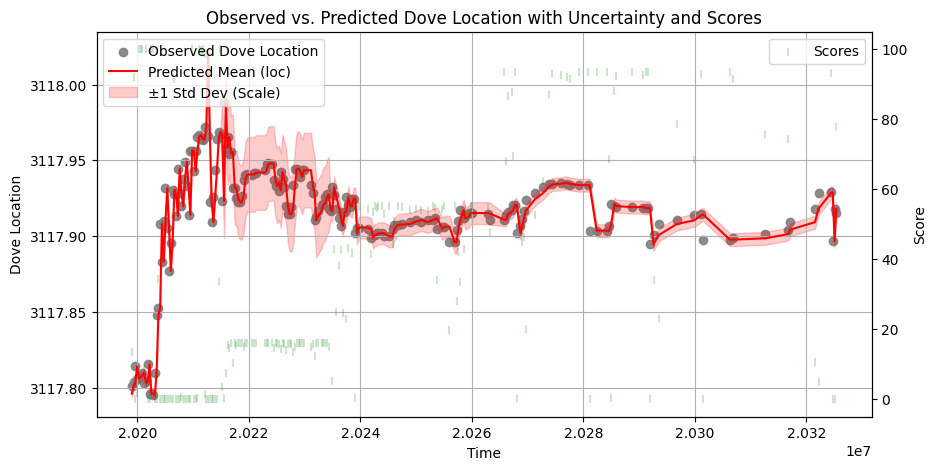

In [26]:
from birdgame.visualization.viz_predictions import plot_dove_predictions
start_ind=8000
window_size=200
plot_dove_predictions(store_pred, start_ind, window_size)